## Reducing Variance in Online Optimization by Transporting Past Gradients – Google Brain
The goal of this report is to demonstrate the ability to understand and explain the results of an academic paper related to machine learning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Background
Stochastic gradient descent (SGD) uses one data point per iteration to estimate the gradient of the loss function. Although it is computationally efficient, SGD introduces significant variance into the calculation of the gradient. Here are some visualizations to get some inution about this method:


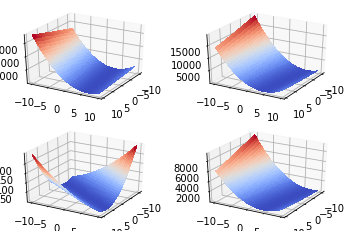

In [38]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
##generate some data for y=5x+3  with noise
eps = np.random.randn(50)
x = np.linspace(-10,10,num=50)
y = (5*x+3)+eps

def loss(theta,x,y):
    L=0
    for i in range(len(x)):
        L+= (theta[0]+theta[1]*x[i]-y[i])**2
    return L/len(x)

##how does our loss function change for different data points?
X = np.arange(-10, 10, 0.5)
Y = np.arange(-10, 10, 0.5)
X, Y = np.meshgrid(X, Y)
def Z(x,y):
    Z = np.zeros(X.shape)
    for i in range(len(X)):
        for j in range(len(X[0])):
            Z[i][j] = loss([X[i][j],Y[i][j]],x,y)
    return Z  
##pick some rando points
fig = plt.figure()
ax = fig.add_subplot(221, projection='3d')
surf = ax.plot_surface(X, Y, Z([x[4]],[y[4]]), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
ax.view_init(30, 30)
ax = fig.add_subplot(222, projection='3d')
surf = ax.plot_surface(X, Y, Z([x[45]],[y[45]]), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
ax.view_init(30, 30)
ax = fig.add_subplot(223, projection='3d')
surf = ax.plot_surface(X, Y, Z([x[23]],[y[23]]), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
ax.view_init(30, 30)
ax = fig.add_subplot(224, projection='3d')
surf = ax.plot_surface(X, Y, Z([x[38]],[y[38]]), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
ax.view_init(30, 30)



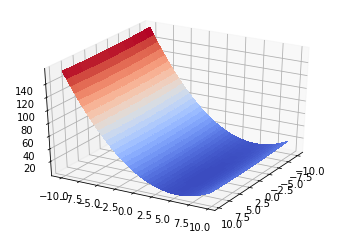

In [39]:
fig = plt.figure()
ax.view_init(30, 30)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z(x,y)/50, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
ax.view_init(30, 30)

The final 3-D plot shows the complete loss function for this data set, which is a sum of squared errors. When we do SGD, we estimate our loss function as just one summand, and compute the gradient from that loss function. The 4 subplots show how the loss function looks different for different data points. We can extend this intuition to the online learning setting: incoming data can change the shape of our overall loss function, leading to the idea of "staleness."

To minimize this variance, some SGD methods use a weighted average of past gradients in their update formula. This average can be thought of as momentum for the path of steepest descent. Gradient components that repeatedly have the same direction cause acceleration whereas gradient components that oscillate back and forth average out to zero, smoothing the path. This comparison with physical momentum is limited, however: remember that for SGD our individual loss functions are different at each data point, so the loss surface itself is changing. 


In the online learning setting, one issue with computing the current gradient based on past gradients is referred to as “staleness.” As we receive new data points, the loss function changes, and past gradients may have pointed us in a direction that we no longer want to go. However, it is not always computationally feasible to store every data point and compute the gradient based on this entire dataset. This paper addresses this issue through "implicit gradient transport" (IGT).


### Momentum doesn't reduce variance
Section 2 of this paper analyzes and visualizes the effect of momentum on gradient variance. To be clear, the variance we are referring to is the difference between how far we are from the optimal parameters and the expected value for how far we are from the optimal parameters $\theta^*$:
$$
\begin{align}
\theta_t-\theta^*= \Delta_t\\
\Delta_t-E[\Delta_t] = \alpha \sum_{i=1}^{t} N_{i,t}\epsilon_i\\ 
\end{align}
$$
Where $N_{i,t}$ is the impact of each data point on the total variance at time $t$ and $\epsilon_i$ is the error for data point i (we can solve for this if we know the full gradient). If we assume at each iteration that the computed gradient is equal to the true gradient plus some error, then we can trace the contribution of these gradients to the overall variance of the gradient through subsequent iterations. The intuition here is that the contribution of the noise from past data points depends only on how recently that data point was used, not on the total number of iterations. The first thought to address this problem would be to decrease the influence of that data point on our current calculation as we iterate (increase the momentum term as a function of iteration number). However, this does not address the heart of the problem - the momentum term still captures and propagates variance from past iterations. If we are trying to reduce overall variance, then the noise from each past data point and gradient calculation needs to converge.

### IGT
This paper asserts that "As momentum uses stale gradients, the velocity is an average of current and
past gradients and thus can be seen as an estimate of the true gradient at a point which is not the
current one but rather a convex combination of past iterates" (4). Remember that these older gradients represent a different loss function than the one we are currently evaluating. The authors are saying here that the variance from previous iterations causes us to get "lost" - we can find where we are supposed to be by using information from past gradients. The paper presents the algorithm by first describing conditions under which the algorithm theoretically converges, and then describes how the algorithm still works if these conditions are not met.

The goal is to obtain the best possible estimate of the full gradient, $g_t(\theta_t)$. Notice how this gradient is indexed by time - it will change as new data points arrive. We do this with a weighted average:
\begin{align}
\dfrac{1}{t+1}g(\theta,x_t) + \dfrac{t}{t+1}\hat{g_{t-1}}(\theta_{t-1}) \approx g_t(\theta_t)\\
\end{align}

where $\hat{g_{t-1}}(\theta_{t-1})$ is an estimate (with noise) of the previous iteration's full gradient. The authors use the assumption that the loss function is a quadratic (for example MSE) and that the Hessian of the loss function does not change with each iteration. The Hessian contains information about how the gradient will change (think about an inflection point where the second derivative is 0), and this information can give us a better idea of where we should be evaluating the current gradient.The second assumption does often hold in practice, but it lets us transfer the Hessian from $g_{t-1}$ to $g$ and leads to the following formula:
\begin{align}
g_t(\theta_t) \approx \dfrac{1}{t+1}g(\theta_t+t(\theta_t-\theta_{t-1}),x_t) + \dfrac{t}{t+1}\hat{g_{t-1}}(\theta_{t-1})\\
\end{align}

This formula is saying that, under certain conditions, we should compute our current gradient at the point $\theta_t+t(\theta_t-\theta_{t-1})$ rather than the current $\theta$. The update formula for $\theta$ is as follows:
\begin{align}
\theta_{t+1} = \dfrac{2t+1}{t+1}\theta_t-\dfrac{t}{t+1}\theta_{t-1}-\dfrac{\alpha}{t+1}g(\theta_t+t(\theta_t-\theta_{t-1}),x_t)\\
\end{align}

The second term is the increasing momentum term which was discussed earlier - this is confusing terminology because it is more akin physically to an increasing friction constant. We also see that we have a decreasing step size in the third term.

### Convergence of Variance
Section 3.3 asserts that the in the offline setting the algorithm converges at rate $O((\dfrac{\sqrt{\kappa}-1}{\sqrt{\kappa}  + 1 }))^t$, and in the online setting, variance is equal to $O(1/t)$ (linear convergence). A very long proof tells us how the variance of theta is bounded by a formula dependent on condition number and stochastic gradient covariance. This algorithm can replace heavy-ball SGD, as variance converges for quadratic loss functions. Here is the code for the update formula: 

In [61]:
def heavy_ball_IGT(alpha,mu,theta_0,grad,X,Y):
    v = grad(theta_0,X[0],Y[0])
    w = -alpha*v
    theta = theta_0 + w
    theta_prev=theta_0
    for t in range(1,len(X)):
        gamma = t/(t+1)
        v = gamma*v + (1-gamma)*grad(theta+(gamma/(1-gamma))*(theta-theta_prev),X[t],Y[t])
        w = mu*w -alpha*v
        theta_prev=theta
        theta = theta+w
        #print(loss(theta,x,y))
    return theta

In [88]:
##gradient for 2-D line with MSE
def grad(theta,x,y):
    l = (theta[0]+theta[1]*x-y)
    return np.array([2*l,2*l*x])
##test - should be -2,4
print(grad([1,1],2,4))

x = np.linspace(-10,10,num=50)
##shuffle them cards
np.random.shuffle(x)
y = (5*x)+eps

theta = (np.random.rand(2)-1)/10
theta = heavy_ball_IGT(1e-4,.9,theta,grad,x,y)
print(theta) 


[-2 -4]
[-0.22443266  5.16356326]


Looks like we are doing OK here - our objective is theta=[0,5]. The next section of the paper describes a technique called "anytime tail averaging" which basically takes a fraction of total gradients to further bias the gradient calculation toward recent terms. This technique is meant to make up for the fact that our individual loss functions do not actually have identical gradients. 
One of the main benefits of IGT is that we do not need to reduce the step size, meaning faster convergence. Section 5 of the paper details and visualizes how IGT can acheive convergence on a quadratic loss function, whereas SGD cannot because of lingering variance. 

## Results and Conclusion
While this algorithm has theoretical advantages over SGD, it performs about the same or slightly better than other SGD variants. The performance validates the theory that this algorithm is based on, and paves the way for more variance reduction techniques. The authors mention in the conclusion that there is potential for further study on the connection between "curvature adaptation" and variance reduction.

This report can be considered a work in progress as I continue to gain a deeper understanding of ML. There are elements of this paper that I do not understand that I will continue to explore. One takeaway from this project is a stronger interest in SGD methods - I think it is cool that we are actually changing the loss function surface at each iteration and that this presents variance problems. It was useful to visualize this effect, and I think it is misleading that SGD is often visualized as a squigly line on a single loss surface, which does not give proper intuition as to where the variance comes from.

####  Work Cited: 
S.MR Arnold, P.A. Manzagol, R. Babanezhad, I. Mitliagkas, and N.L. Roux. Reducing the variance in online optimization by transporting past gradients. arXiv preprint arXiv:1906.03532, 2019.